In [1]:
!pip install imutils


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=b8ad29db55ccf878b893ab6b1969ee5da218d33dadff368a84fa5542c70ec0ee
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3 
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers.core import Dense,Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

import tensorflow as tf
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics


# Load image paths from the respective directories


In [3]:
train_dir = '../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL'
test_dir = '../input/test-data/Test'

In [4]:
train_list = sorted(list(paths.list_images(train_dir)))
test_list = sorted(list(paths.list_images(test_dir)))

print('Number of testing images:', len(test_list))
print('Number of training images:', len(train_list))

Number of testing images: 400
Number of training images: 3600


1-1: Create temporary folders

In [5]:
!mkdir /tmp/prepared_data/

!mkdir /tmp/prepared_data/benign
!mkdir /tmp/prepared_data/PreB
!mkdir /tmp/prepared_data/ProB
!mkdir /tmp/prepared_data/EarlyPreB

!mkdir /tmp/prepared_test/

!mkdir /tmp/prepared_test/benign
!mkdir /tmp/prepared_test/PreB
!mkdir /tmp/prepared_test/ProB
!mkdir /tmp/prepared_test/EarlyPreB

In [6]:
# # Create directories for augmented data
# os.makedirs('/tmp/prepared_data/benign', exist_ok=True)
# os.makedirs('/tmp/prepared_data/PreB', exist_ok=True)
# os.makedirs('/tmp/prepared_data/ProB', exist_ok=True)
# os.makedirs('/tmp/prepared_data/EarlyPreB', exist_ok=True)
# os.makedirs('/tmp/prepared_test/benign', exist_ok=True)
# os.makedirs('/tmp/prepared_test/PreB', exist_ok=True)
# os.makedirs('/tmp/prepared_test/ProB', exist_ok=True)
# os.makedirs('/tmp/prepared_test/EarlyPreB', exist_ok=True)

1-2: Splitting data into testing data and training data (10/90)

In [7]:
# data_dir  = '../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
# data_list = sorted(list(paths.list_images(data_dir)))

# random.seed(88)
# random.shuffle(data_list)

# train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

# print('number of testing list -:',len(test_list))
# print('number of training list-:',len(train_list))

In [8]:
print('Number of samples in dataset:',len(list(paths.list_images("../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL"))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images("../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images("../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL/Malignant early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL/Malignant Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images("../input/blood-cell-cancer-leukemia/Blood cell Cancer ALL/Malignant Pro-B"))))

Number of samples in dataset: 3600 

Number of samples in each class: 

#1 Benign ---------------: 900
#2 Malignant[Early PreB] : 900
#3 Malignant[PreB] ------: 900
#4 Malignant[ProB] ------: 900


1-3: Preparation and storage of test data

In [9]:
p=0

for img in test_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
  
    if (lable=="Benign"):
        b= ('/tmp/prepared_test/benign/'+lable+str(p)+'.png') 
    if (lable=="Pre-B"):
        b= ('/tmp/prepared_test/PreB/'+lable+str(p)+'.png')  
    if (lable=="Pro-B"):
        b= ('/tmp/prepared_test/ProB/'+lable+str(p)+'.png') 
    if (lable=="Early pre-B"):
        b= ('/tmp/prepared_test/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)

1-4: Preparation and storage of training data

- Description:  each original sample of the training data is segmented and then stored with the original sample as two separate samples. 

In [10]:
p=0
tic = time.perf_counter()

for img in train_list[:]:
    
    i= cv2.imread(img)    
    i= cv2.resize(i,(224,224))
    lable= img.split(os.path.sep)[4]
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="Malignant Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="Malignant Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="Malignant early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    cv2.imwrite(b,i)
    
    #-------- Segmentation ---------
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        #RGB -> LAB
    l,a,b = cv2.split(i_lab)                         
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)  #Clustring
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY) #Binary Thresholding
    fh = ndi.binary_fill_holes(t)                      #fill holes
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    m2 = m2.astype(np.uint8)  
    out = cv2.bitwise_and(i, i, mask=m2)
    
    if (lable=="Benign"):
        b= ('/tmp/prepared_data/benign/'+lable+str(p)+'.png') 
    if (lable=="Malignant Pre-B"):
        b= ('/tmp/prepared_data/PreB/'+lable+str(p)+'.png')  
    if (lable=="Malignant Pro-B"):
        b= ('/tmp/prepared_data/ProB/'+lable+str(p)+'.png') 
    if (lable=="Malignant early Pre-B"):
        b= ('/tmp/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
    p+=1
    out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
    cv2.imwrite(b,out)
    
toc2 = time.perf_counter()
print(f"3600 samples processed in { ((toc2 - tic)/60) } minutes")

3600 samples processed in 15.787003787700003 minutes


In [11]:
# #----- print some samples of training dataset -------

# n= 3

# o_img=[] #Original images
# a_img=[] #A channel of LAB color space
# c_img=[] #Clustered images
# b_img=[] #Binary thresholded images
# m_img=[] #Processed binary images
# out_img=[] #Final images

# random.seed(865)
# random.shuffle(data_list)

# for img in data_list[:n]:
#     i= cv2.imread(img)    
#     i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
#     i= cv2.resize(i,(224,224))
#     o_img.append(i)
#     i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
#     l,a,b = cv2.split(i_lab)
#     a_img.append(a)
#     i2 = a.reshape(a.shape[0]*a.shape[1],1)
#     km= KMeans(n_clusters=7, random_state=0).fit(i2)
#     p2s= km.cluster_centers_[km.labels_]
#     ic= p2s.reshape(a.shape[0],a.shape[1])
#     ic = ic.astype(np.uint8)
#     c_img.append(ic)
#     r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
#     b_img.append(t)    
#     fh = ndi.binary_fill_holes(t)   
#     m1 = morphology.remove_small_objects(fh, 200)
#     m2 = morphology.remove_small_holes(m1,250)
#     #m2 = ndi.binary_fill_holes(m2)  
#     #m1 = m1.astype(np.uint8)
#     #m1_imgs.append(m1)
#     m2 = m2.astype(np.uint8)  
#     m_img.append(m2)
#     out = cv2.bitwise_and(i, i, mask=m2)
#     out_img.append(out)
    
# for j in range(n):    
#     for t in range(1):
#         #print('=>',j+1,':')
#         plt.subplot(2,3,1+t),plt.imshow(o_img[j])
#         plt.title('a'),plt.xticks([]),plt.yticks([])
#         plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
#         plt.title('b'),plt.xticks([]),plt.yticks([])
#         plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
#         plt.title('c'),plt.xticks([]),plt.yticks([])
#         plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
#         plt.title('d'),plt.xticks([]),plt.yticks([])
#         plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
#         plt.title('e'),plt.xticks([]),plt.yticks([])
#         plt.subplot(2,3,6+t),plt.imshow(out_img[j])
#         plt.title('f'),plt.xticks([]),plt.yticks([])
#     plt.show()      

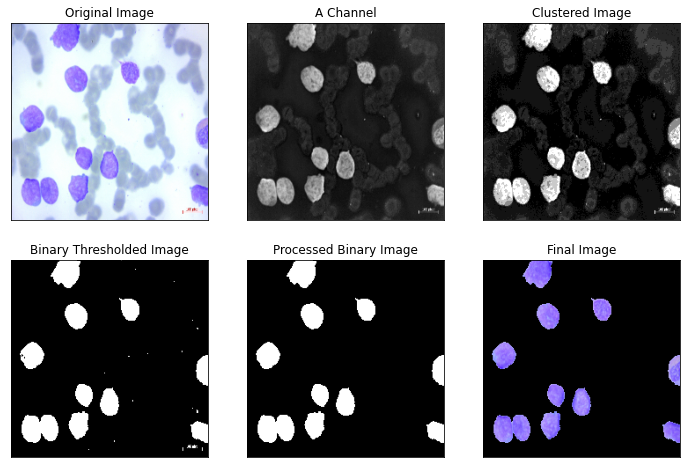

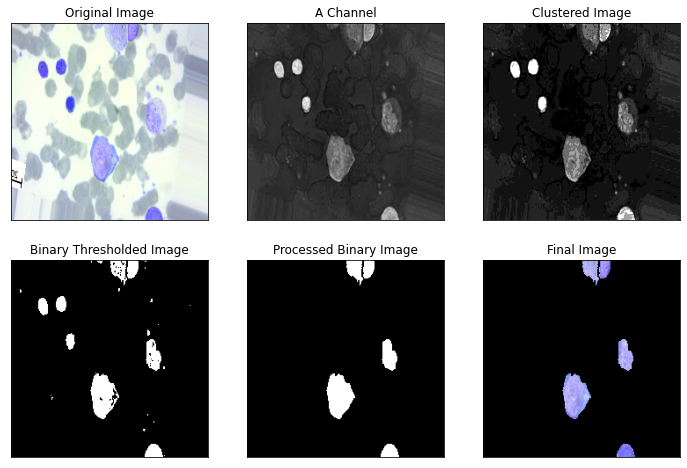

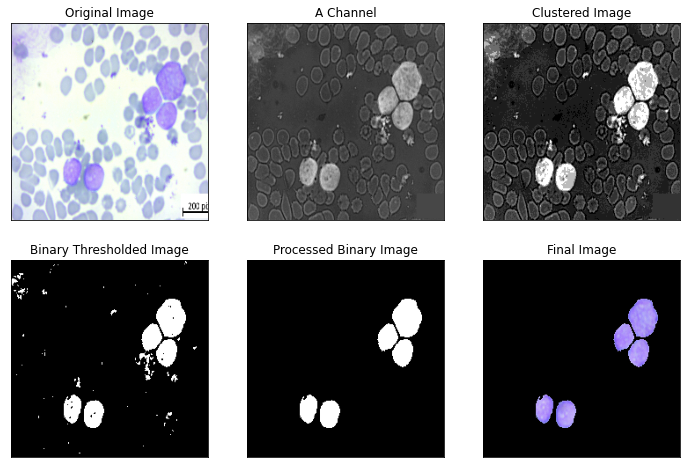

In [12]:
#----- print some samples of training dataset -------

import matplotlib.pyplot as plt

n = 3

o_img = []  # Original images
a_img = []  # A channel of LAB color space
c_img = []  # Clustered images
b_img = []  # Binary thresholded images
m_img = []  # Processed binary images
out_img = []  # Final images

random.seed(865)
random.shuffle(train_list)

for img in train_list[:n]:
    i = cv2.imread(img)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i = cv2.resize(i, (224, 224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0] * a.shape[1], 1)
    km = KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s = km.cluster_centers_[km.labels_]
    ic = p2s.reshape(a.shape[0], a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r, t = cv2.threshold(ic, 141, 255, cv2.THRESH_BINARY)
    b_img.append(t)
    fh = ndi.binary_fill_holes(t)
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1, 250)
    m2 = m2.astype(np.uint8)
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)

for j in range(n):
    for t in range(1):
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 3, 1 + t), plt.imshow(o_img[j])
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(2, 3, 2 + t), plt.imshow(a_img[j], cmap='gray')
        plt.title('A Channel'), plt.xticks([]), plt.yticks([])
        plt.subplot(2, 3, 3 + t), plt.imshow(c_img[j], cmap='gray')
        plt.title('Clustered Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(2, 3, 4 + t), plt.imshow(b_img[j], cmap='gray')
        plt.title('Binary Thresholded Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(2, 3, 5 + t), plt.imshow(m_img[j], cmap='gray')
        plt.title('Processed Binary Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(2, 3, 6 + t), plt.imshow(out_img[j])
        plt.title('Final Image'), plt.xticks([]), plt.yticks([])
        plt.savefig('/kaggle/working/processed_img.png', dpi=300)
        plt.show()


# **Step 2:** Prepare data for training

2-1: Create dataframe from prepared data

In [13]:
#------- test Datafarame ---------

prepared_data_path = '/tmp/prepared_test/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
test_df = pd.concat( [I_series, L_series], axis=1) 

print('-- test Datafarame --')
print(test_df.head())
#print number of each class:        
a=test_df['labels'].value_counts()
a



-- test Datafarame --
                                         filenames     labels
0           /tmp/prepared_test/benign/Benign29.png     benign
1             /tmp/prepared_test/ProB/Pro-B300.png       ProB
2  /tmp/prepared_test/EarlyPreB/Early pre-B112.png  EarlyPreB
3           /tmp/prepared_test/benign/Benign83.png     benign
4             /tmp/prepared_test/ProB/Pro-B303.png       ProB


benign       100
ProB         100
EarlyPreB    100
PreB         100
Name: labels, dtype: int64

In [14]:

prepared_data_path = '/tmp/prepared_data/'
prepared_data_list_filenames = (sorted(list(paths.list_images(prepared_data_path))))
random.shuffle(prepared_data_list_filenames)
prepared_data_list_labels = []

for line in prepared_data_list_filenames:
    prepared_data_list_labels.append(line.split(os.path.sep)[3])

I_series = pd.Series(prepared_data_list_filenames, name='filenames')
L_series = pd.Series(prepared_data_list_labels, name='labels')
df = pd.concat( [I_series, L_series], axis=1) 

print('-- train/valid Datafarame --')

print(df.head())
#print number of each class:        
a=df['labels'].value_counts()
a

-- train/valid Datafarame --
                                           filenames     labels
0  /tmp/prepared_data/EarlyPreB/Malignant early P...  EarlyPreB
1           /tmp/prepared_data/benign/Benign1471.png     benign
2           /tmp/prepared_data/benign/Benign1084.png     benign
3    /tmp/prepared_data/ProB/Malignant Pro-B4681.png       ProB
4  /tmp/prepared_data/EarlyPreB/Malignant early P...  EarlyPreB


EarlyPreB    1800
benign       1800
ProB         1800
PreB         1800
Name: labels, dtype: int64

In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="darkgrid")
# plt.figure(figsize=(10,8))
# sns.barplot(x= ['EarlyPreB','PreB','ProB','Benign'], y= [a[0],a[1],a[2],a[3]])
# plt.title('Number of All the Data', fontsize=14)
# plt.xlabel('Case type', fontsize=12)
# plt.ylabel('Count', fontsize=12)
# #plt.xticks(range(len(df.index)), ['a', 'b'])
# plt.show()

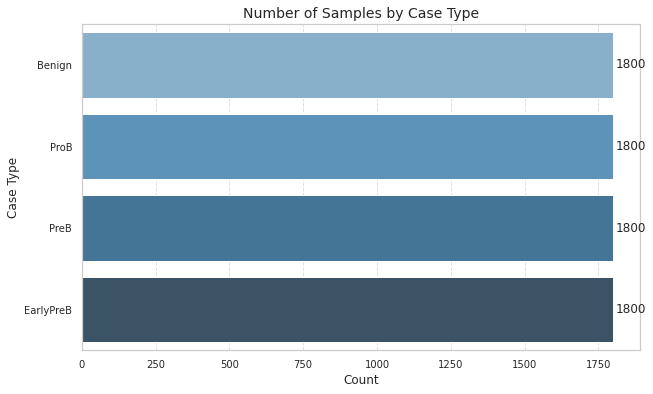

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data (replace with your actual counts)
counts = [a[3], a[2], a[1], a[0]]
categories = ['Benign', 'ProB', 'PreB', 'EarlyPreB']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a barplot
ax = sns.barplot(x=counts, y=categories, palette="Blues_d")

# Add labels to the bars
for i, count in enumerate(counts):
    ax.text(count + 10, i, str(count), va='center', fontsize=12)

plt.title('Number of Samples by Case Type', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Case Type', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Show the plot
plt.savefig('/kaggle/working/N_samples.png', dpi=300)
plt.show()


2-2: Split the data frame for training and validation sets


In [17]:
SPLIT= 0.90

TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88)

print('Train samples: ', len(TRAIN_DF))
print('Valid samples: ', len(VALID_DF))
print('Test samples : ', len(test_df))

Train samples:  6480
Valid samples:  720
Test samples :  400


In [18]:
test_df['labels'].value_counts()

benign       100
ProB         100
EarlyPreB    100
PreB         100
Name: labels, dtype: int64

In [19]:
BATCH_SIZE= 32
IMG_SHAPE= (224, 224, 3)
IMG_SIZE= (224, 224)

# Data augmentation for training images
gen = ImageDataGenerator(rescale=1./255, 
                         vertical_flip=True,
                         horizontal_flip=True)
                         #rotation_range=10)

gen2 = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(TRAIN_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)

valid_gen= gen2.flow_from_dataframe(VALID_DF,
                                    x_col= 'filenames',
                                    y_col= 'labels',
                                    target_size= IMG_SIZE,
                                    class_mode= 'categorical',
                                    color_mode= 'rgb',
                                    shuffle= True,
                                    batch_size= BATCH_SIZE,
                                    seed=88
)
test_gen= gen2.flow_from_dataframe(test_df,
                                   x_col= 'filenames',
                                   y_col= 'labels',
                                   target_size= IMG_SIZE,
                                   class_mode= 'categorical',
                                   color_mode= 'rgb',
                                   shuffle= True,
                                   batch_size= 400,
                                   seed=88
)


STEPS= int( len(train_gen.labels)/BATCH_SIZE)
print(STEPS)

Found 6480 validated image filenames belonging to 4 classes.
Found 720 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
202


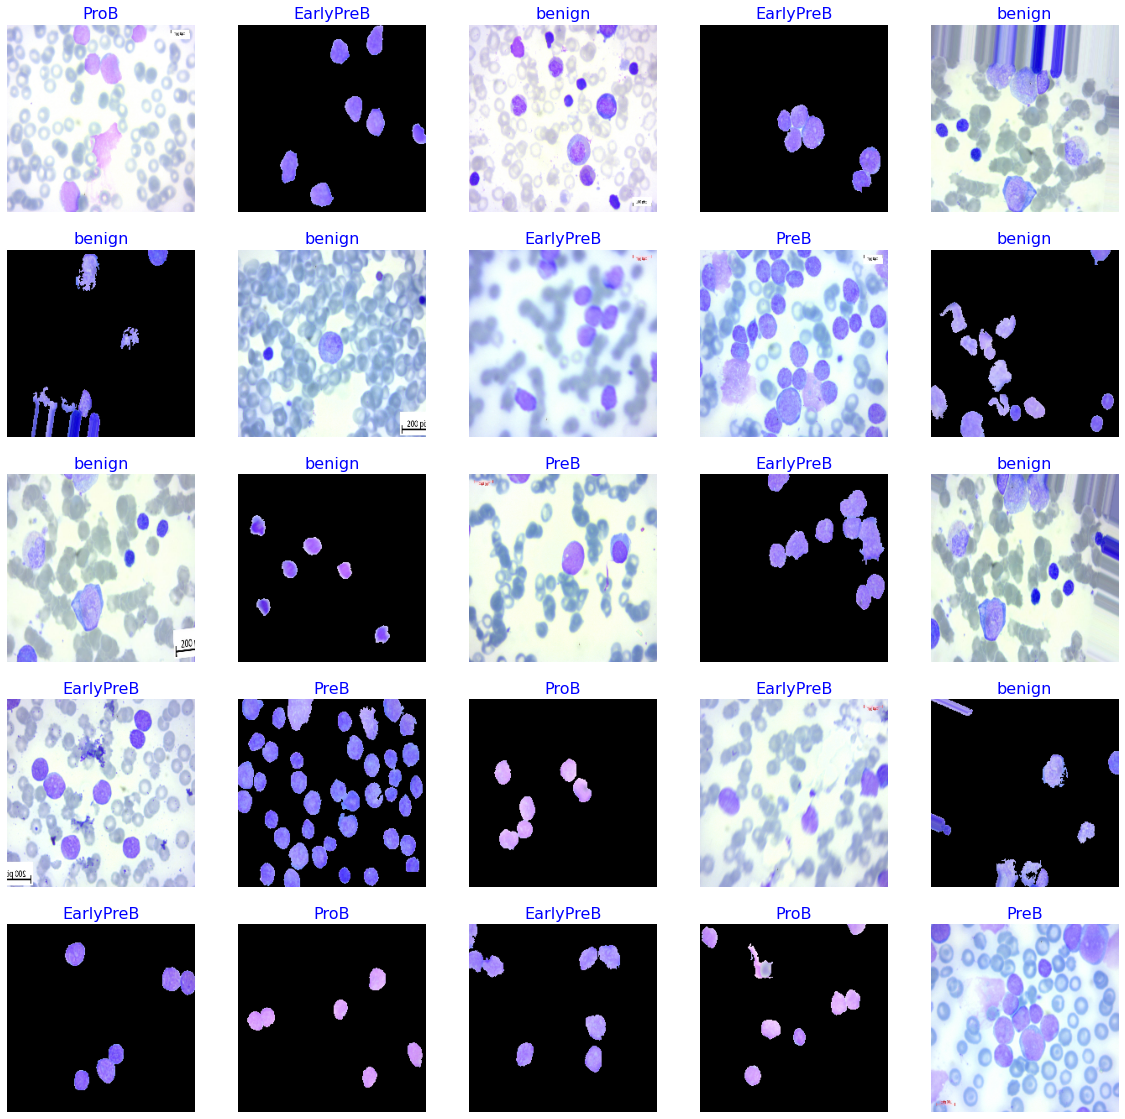

In [20]:

genn=train_gen
class_dictionary= genn.class_indices
class_names = list(class_dictionary.keys())
images, labels = next(genn) #get sample batch from the generator
plt.figure(figsize=(20,20))
length = len(labels)

if length<25:
    r=length
else:
    r=25

for i in range(r):
    plt.subplot(5, 5, i+1)
    image= (images[i])
    #image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name= class_names[index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
plt.show()

In [21]:
#base_model = InceptionV3(include_top= False, weights="imagenet", input_shape=(224,224,3)) #99.50%
#base_model= tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.nasnet.NASNetLarge
#base_model= tf.keras.applications.nasnet.NASNetMobile(include_top=False,weights='imagenet',input_shape=(224,224,3))
#base_model= tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
#tf.keras.applications.MobileNetV3Small
#base_model= tf.keras.applications.ResNet152V2(include_top=False,weights='imagenet',input_shape=(224,224,3)) 
#base_model= tf.keras.applications.InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(224,224,3))
#base_model= tf.keras.applications.ResNet101(include_top=False,weights='imagenet',input_shape=(224,224,3))
#base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#base_model = tf.keras.applications.nasnet.NASNetLarge(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))




x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

# from tensorflow.keras.layers import Layer

# class SelfAttention(Layer):
#     def __init__(self, units):
#         super(SelfAttention, self).__init__()
#         self.units = units

#     def build(self, input_shape):
#         self.W_q = self.add_weight(shape=(input_shape[-1], self.units),
#                                   initializer='glorot_uniform',
#                                   trainable=True)
#         self.W_k = self.add_weight(shape=(input_shape[-1], self.units),
#                                   initializer='glorot_uniform',
#                                   trainable=True)
#         self.W_v = self.add_weight(shape=(input_shape[-1], self.units),
#                                   initializer='glorot_uniform',
#                                   trainable=True)
#         super(SelfAttention, self).build(input_shape)

#     def call(self, x):
#         q = tf.matmul(x, self.W_q)
#         k = tf.matmul(x, self.W_k)
#         v = tf.matmul(x, self.W_v)

#         attention_scores = tf.matmul(q, k, transpose_b=True)
#         attention_weights = tf.nn.softmax(attention_scores, axis=-1)
#         attended_output = tf.matmul(attention_weights, v)

#         return attended_output

#     # Add the SelfAttention layer
# x = SelfAttention(units=32)(x)

#x = Dense(128, activation= 'relu',kernel_initializer='he_uniform')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.3)(x)


predictions = Dense(4, activation= "softmax")(x) 
model = Model(inputs=base_model.input, outputs=predictions) 

80150528/80134624 [==============================] - 0s 0us/step


In [22]:
# Layers of the base model should learn
for layer in base_model.layers:
    layer.trainable = True

In [23]:
# # # Add custom layers on top of the base model
# from tensorflow.keras.layers import Flatten, Dense, Dropout
# from tensorflow.keras import regularizers
# flatten_layer = Flatten()(base_model.output)
# hidden_layer1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flatten_layer)
# dropout_layer1 = Dropout(0.4)(hidden_layer1)
# hidden_layer2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(dropout_layer1)
# dropout_layer2 = Dropout(0.5)(hidden_layer2)
# #hidden_layer3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_layer2)
# #dropout_layer3 = Dropout(0.4)(hidden_layer3)
# # hidden_layer4 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_layer3)
# # dropout_layer4 = Dropout(0.5)(hidden_layer4)
# # hidden_layer5 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_layer4)
# # dropout_layer5 = Dropout(0.5)(hidden_layer5)



# # #Add another Flatten layer
# # # flatten_layer2 = Flatten()(dropout_layer2)

# # # # Continue with your custom layers
# # # hidden_layer3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(flatten_layer2)
# # # dropout_layer3 = Dropout(0.5)(hidden_layer3)
# # # hidden_layer4 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_layer3)
# # # dropout_layer4 = Dropout(0.5)(hidden_layer4)

# # # Output layer
# output_layer = Dense(4, activation='softmax')(dropout_layer2)

# # # Define the final model
# model = Model(inputs=base_model.input, outputs=output_layer)

In [64]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import tensorflow as tf

# Assuming 'base_model' is defined and pre-trained

flatten_layer = Flatten()(base_model.output)

# First hidden layer with Batch Normalization
hidden_layer1 = Dense(128, activation='ReLU', kernel_regularizer=regularizers.l2(0.001))(flatten_layer)
batch_norm1 = BatchNormalization()(hidden_layer1)
dropout_layer1 = Dropout(0.5)(batch_norm1)

# Second hidden layer with Batch Normalization
hidden_layer2 = Dense(156, activation='ReLU', kernel_regularizer=regularizers.l2(0.01))(dropout_layer1)
batch_norm2 = BatchNormalization()(hidden_layer2)
dropout_layer2 = Dropout(0.4)(batch_norm2)


# Output layer
output_layer = Dense(4, activation='softmax')(dropout_layer2)

# Define the final model
model = Model(inputs=base_model.input, outputs=output_layer)

In [25]:
# print(base_model.input)
# model.summary()

In [26]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, show_shapes=True, show_layer_names=True)

3-2: Model parameters

In [27]:
# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=False)


# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08), #optimizer=Adam(learning_rate=0.00001,decay = 10e-5),
#               metrics=['accuracy'])
#              # option = run_opts)

In [28]:
# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC, Recall, Precision

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=False)

# # Define AUC, Recall, and Precision metrics for multi-class classification
# auc_metrics = [AUC(name=f'auc_class_{i}') for i in range(4)]  # Create AUC metrics for each class
# recall_metrics = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(4)]  # Create Recall metrics for each class
# precision_metrics = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(4)]  # Create Precision metrics for each class

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
#               metrics=['accuracy'] + auc_metrics + recall_metrics + precision_metrics)

# import tensorflow as tf
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import AUC, Recall, Precision

# initial_learning_rate = 0.0001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=40,
#     decay_rate=0.96,
#     staircase=False)

# # Define AUC, Recall, and Precision metrics for overall multi-class classification
# auc_metric = AUC(name='auc')
# recall_metric = Recall(name='recall')
# precision_metric = Precision(name='precision')

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
#               metrics=['accuracy', auc_metric, recall_metric, precision_metric])




In [65]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall, Precision
from sklearn.metrics import f1_score
from functools import partial

initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=40,
    decay_rate=0.96,
    staircase=False)

# Define AUC, Recall, Precision, and F1 score metrics for overall multi-class classification
auc_metric = AUC(name='auc')
recall_metric = Recall(name='recall')
precision_metric = Precision(name='precision')

# Define a custom F1 score metric using a function and functools.partial
def f1_score_metric(y_true, y_pred, average='micro'):
    return tf.py_function(partial(f1_score, average=average), (y_true, tf.round(y_pred)), tf.float32, name='f1_score')

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
              metrics=['accuracy', auc_metric, recall_metric, precision_metric, f1_score_metric])




3-2: Model training

In [30]:
# os.mkdir('/kaggle/working/saved_models')
# os.mkdir('/kaggle/working/saved_logs')

In [31]:
# #Add Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
# from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# #patience = 3

# #ModelCheckpoint callback saves a model at some interval.

# #Give unique name to save all models as accuracy improves
# filepath="/kaggle/working/saved_models/best_models.hdf5" #File name includes epoch and validation accuracy.

# #Overwrite the model each time accuracy improves. Saves a lot of space.
# #filepath="/content/drive/MyDrive/Colab Notebooks/saved_models/best_model.hdf5" #File name includes epoch and validation accuracy.
# #Use Mode = max for accuracy and min for loss.
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=patience, verbose=1)
# #This callback will stop the training when there is no improvement in
# # the validation loss for three consecutive epochs.

# #CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
# log_csv = CSVLogger('/kaggle/working/saved_logs/my_logs.csv', separator=',', append=False)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=patience, verbose=1)

# callbacks_list = [checkpoint, early_stop, log_csv,reduce_lr]

In [32]:
# from keras.callbacks import Callback

# class EarlyStoppingOnDecrease(Callback):
#     def __init__(self, monitor='val_accuracy', min_delta=0, patience=3, verbose=1):
#         super(EarlyStoppingOnDecrease, self).__init__()
#         self.monitor = monitor
#         self.min_delta = min_delta
#         self.patience = patience
#         self.verbose = verbose
#         self.wait = 0
#         self.best = float('-inf')  # Initialize with negative infinity for maximum accuracy

#     def on_epoch_end(self, epoch, logs=None):
#         current = logs.get(self.monitor)
#         if current is None:
#             raise ValueError(f"Unknown metric {self.monitor}.")
        
#         if current - self.best > self.min_delta:
#             self.best = current
#             self.wait = 0
#         else:
#             self.wait += 1
#             if self.wait >= self.patience:
#                 if self.verbose > 0:
#                     print(f"Epoch {epoch + 1}: Early stopping due to decreasing {self.monitor}.")
#                 self.model.stop_training = True

# # Usage:
# early_stopping_callback = EarlyStoppingOnDecrease(monitor='val_loss', patience=10)
# history = model.fit(x=train_gen, epochs=30, validation_data=valid_gen, steps_per_epoch=None, workers=2, callbacks=[early_stopping_callback])


In [ ]:
history =         model.fit(x=train_gen,
                            epochs=30,
                            validation_data=valid_gen,
                            steps_per_epoch=None,
                            workers=2
                   )

Epoch 1/30
203/203 [==============================] - 55s 261ms/step - loss: 1.6782 - accuracy: 0.9463 - auc: 0.9943 - recall: 0.9360 - precision: 0.9551 - f1_score_metric: 0.9440 - val_loss: 1.4655 - val_accuracy: 0.9819 - val_auc: 0.9994 - val_recall: 0.9792 - val_precision: 0.9819 - val_f1_score_metric: 0.9809
Epoch 2/30
203/203 [==============================] - 53s 260ms/step - loss: 1.3949 - accuracy: 0.9798 - auc: 0.9984 - recall: 0.9773 - precision: 0.9823 - f1_score_metric: 0.9798 - val_loss: 1.3135 - val_accuracy: 0.9847 - val_auc: 0.9981 - val_recall: 0.9833 - val_precision: 0.9861 - val_f1_score_metric: 0.9850
Epoch 3/30
203/203 [==============================] - 52s 258ms/step - loss: 1.2463 - accuracy: 0.9819 - auc: 0.9991 - recall: 0.9812 - precision: 0.9836 - f1_score_metric: 0.9821 - val_loss: 1.1608 - val_accuracy: 0.9917 - val_auc: 0.9990 - val_recall: 0.9917 - val_precision: 0.9944 - val_f1_score_metric: 0.9932
Epoch 4/30
203/203 [==============================] - 5

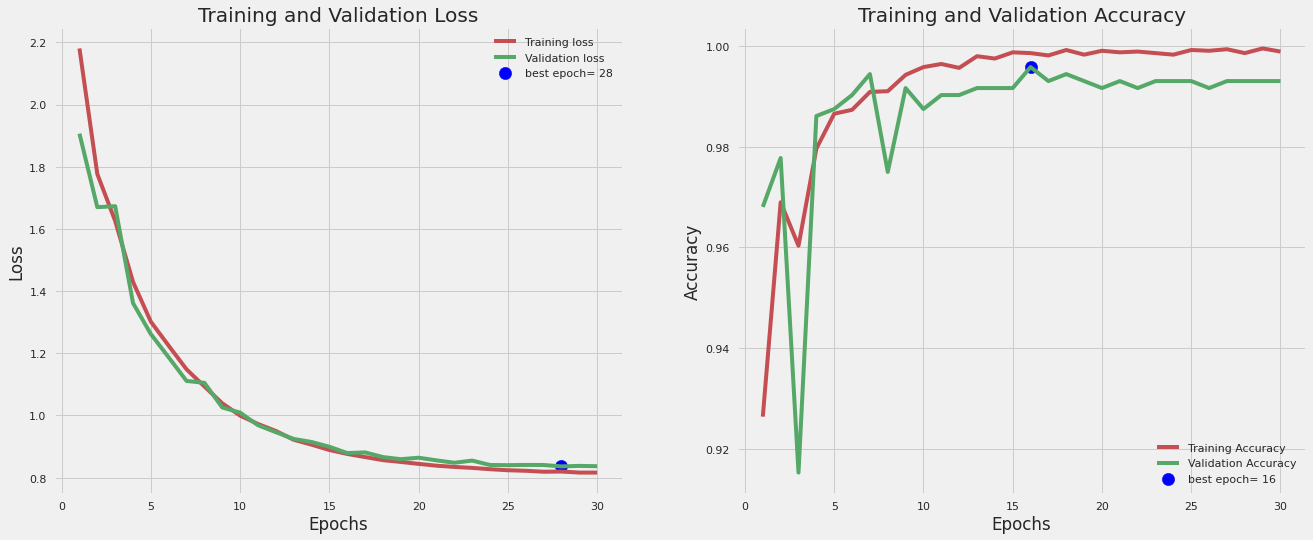

1/1 [==============================] - 2s 2s/step - loss: 0.9253 - accuracy: 0.9800 - auc: 0.9927 - recall: 0.9800 - precision: 0.9800 - f1_score_metric: 0.9800
Model accuracy on test set: 98.00000190734863 (0, 255, 0) (55, 65, 80)


In [63]:
   
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
    
    
tr_plot(history, 0)
acc=model.evaluate(test_gen,batch_size=32, steps=None, verbose=1)[1]*100
msg='Model accuracy on test set: ' + str(acc)
print(msg, (0,255,0), (55,65,80))


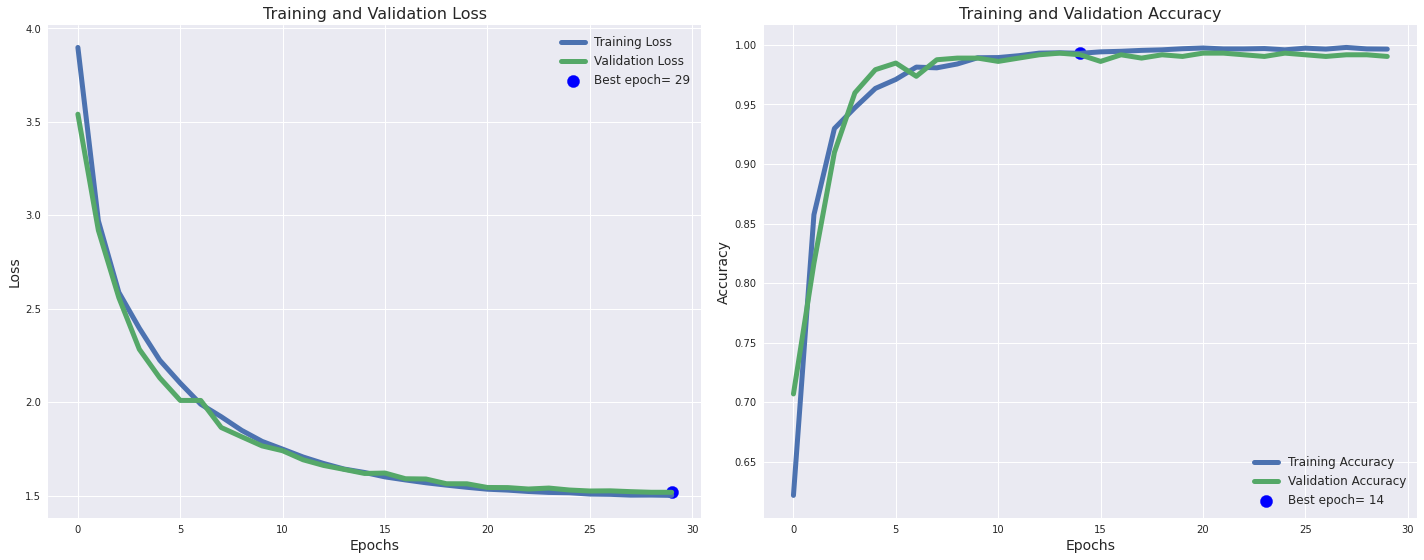

1/1 [==============================] - 2s 2s/step - loss: 1.5991 - accuracy: 0.9775 - auc: 0.9943 - recall: 0.9775 - precision: 0.9775 - f1_score_metric: 0.9775
Model accuracy on the test set: 97.75%


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = list(range(start_epoch, Epoch_count))  # Use a list comprehension for Epochs
    index_loss = np.argmin(vloss)  # This is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    # Use a different style for the plot
    plt.style.use('seaborn')

    sc_label = 'Best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'b-', label='Training Loss', linewidth=5)
    axes[0].plot(Epochs, vloss, 'g-', label='Validation Loss', linewidth=5)
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label, marker='o')
    axes[0].set_title('Training and Validation Loss', fontsize=16)
    axes[0].set_xlabel('Epochs', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].legend(fontsize=12)
    axes[0].grid(True)

    axes[1].plot(Epochs, tacc, 'b-', label='Training Accuracy', linewidth=5)
    axes[1].plot(Epochs, vacc, 'g-', label='Validation Accuracy', linewidth=5)
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label, marker='o')
    axes[1].set_title('Training and Validation Accuracy', fontsize=16)
    axes[1].set_xlabel('Epochs', fontsize=14)
    axes[1].set_ylabel('Accuracy', fontsize=14)
    axes[1].legend(fontsize=12)
    axes[1].grid(True)

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the tr_plot function
tr_plot(history, 0)

# Evaluate and print model accuracy on the test set
acc = model.evaluate(test_gen, batch_size=32, steps=None, verbose=1)[1] * 100
msg = 'Model accuracy on the test set: {:.2f}%'.format(acc)
print(msg)



In [36]:
#from sklearn.metrics import roc_curve, auc

# # Convert test_gen.labels to a numpy array
# test_labels = np.array(test_gen.labels)

# # Step 2: Calculate the AUC for each class
# class_names = ['EarlyPreB', 'PreB', 'ProB', 'benign']
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(class_names)):
#     fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], test_predictions[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Step 3: Plot the AUC curve for each class
# plt.figure(figsize=(10, 6))
# colors = ['b', 'g', 'r', 'c']  # You may need to adjust the colors
# for i in range(len(class_names)):
#     plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Test Dataset')
# plt.legend(loc="lower right")
# plt.show()


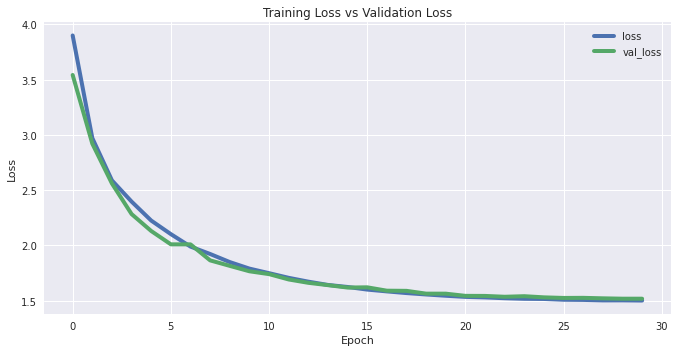

In [37]:
import matplotlib.pyplot as plt

# Your code to create the plot
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="loss", linewidth=4)
plt.plot(history.history["val_loss"], label="val_loss", linewidth=4)
plt.legend()

# Adding a title to the plot
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Save the plot as an image with high DPI (e.g., 300 DPI for high resolution)
plt.savefig('/kaggle/working/Loss.png', dpi=300,bbox_inches='tight')  # Specify the path where you want to save the image




In [38]:
# from sklearn.preprocessing import label_binarize

# # Convert class labels to one-hot encoding for the training dataset
# train_labels_onehot = label_binarize(train_gen.labels, classes=[0, 1, 2, 3])

# # Step 2: Calculate the AUC for each class for the training dataset
# class_names = ['EarlyPreB', 'PreB', 'ProB', 'benign']
# fpr_train = dict()
# tpr_train = dict()
# roc_auc_train = dict()

# for i in range(len(class_names)):
#     fpr_train[i], tpr_train[i], _ = roc_curve(train_labels_onehot[:, i], model.predict(train_gen)[:, i])
#     roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# # Step 3: Plot the AUC curve for each class for the training dataset
# plt.figure(figsize=(10, 6))
# colors = ['b', 'g', 'r', 'c']  # You may need to adjust the colors
# for i in range(len(class_names)):
#     plt.plot(fpr_train[i], tpr_train[i], color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc_train[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Training Dataset')
# plt.legend(loc="lower right")
# plt.show()


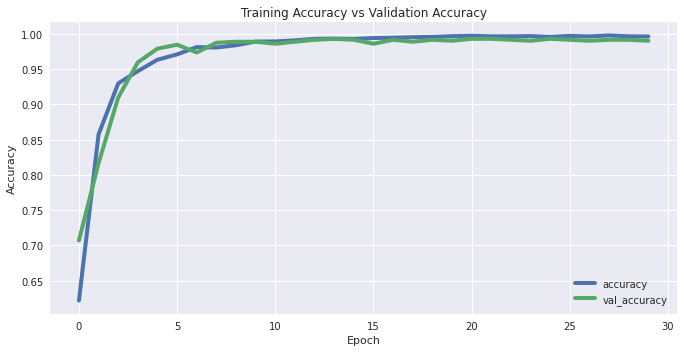

In [39]:
import matplotlib.pyplot as plt

# Your code to create the plot
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="accuracy", linewidth=4)
plt.plot(history.history["val_accuracy"], label="val_accuracy", linewidth=4)
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Save the plot as an image with high DPI (e.g., 300 DPI for high resolution)
plt.savefig('/kaggle/working/Accuracy2.png', dpi=300, bbox_inches='tight')  # Specify the path where you want to save the image

# Display the plot
plt.show()


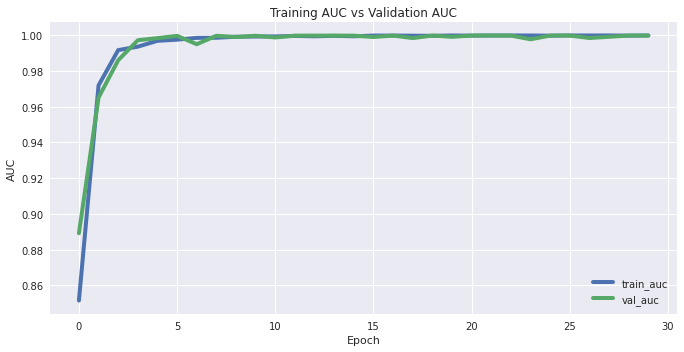

In [40]:
import matplotlib.pyplot as plt

# Plotting train AUC vs val AUC
plt.figure(figsize=(10, 5))
plt.plot(history.history["auc"], label="train_auc", linewidth=4)
plt.plot(history.history["val_auc"], label="val_auc", linewidth=4)
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title("Training AUC vs Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.savefig('/kaggle/working/AUC.png', dpi=300,bbox_inches='tight')
plt.show()


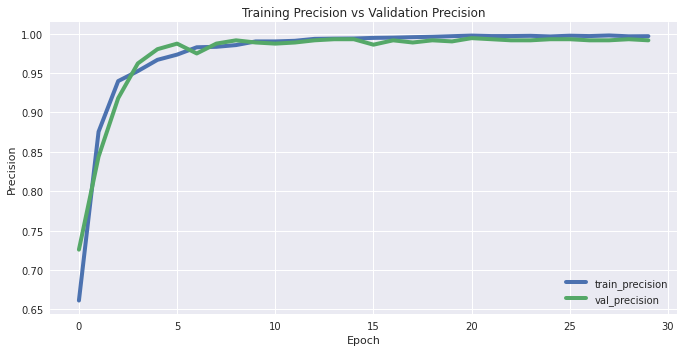

In [41]:
import matplotlib.pyplot as plt

# Plotting train precision vs val precision
plt.figure(figsize=(10, 5))
plt.plot(history.history["precision"], label="train_precision", linewidth=4)
plt.plot(history.history["val_precision"], label="val_precision", linewidth=4)
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title("Training Precision vs Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.savefig('/kaggle/working/Precision.png', dpi=300, bbox_inches='tight')
plt.show()


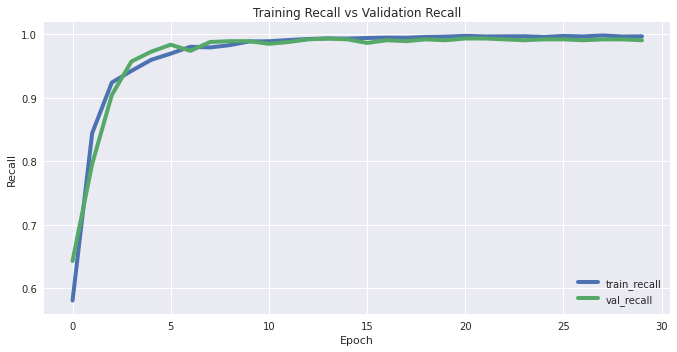

In [42]:
import matplotlib.pyplot as plt

# Plotting train recall vs val recall
plt.figure(figsize=(10, 5))
plt.plot(history.history["recall"], label="train_recall", linewidth=4)
plt.plot(history.history["val_recall"], label="val_recall", linewidth=4)
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title("Training Recall vs Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.savefig('/kaggle/working/recall.png', dpi=300, bbox_inches='tight')
plt.show()


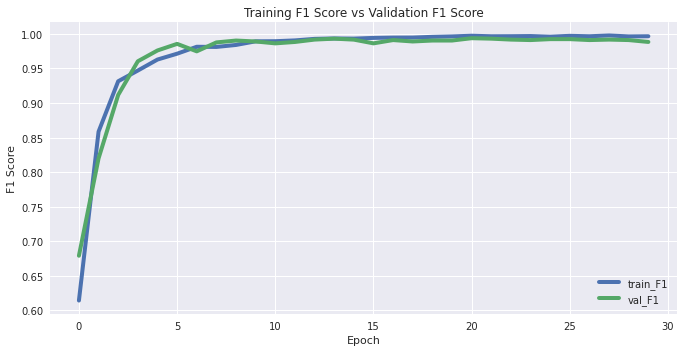

In [43]:
import matplotlib.pyplot as plt

# Plotting train F1 score vs val F1 score
plt.figure(figsize=(10, 5))
plt.plot(history.history["f1_score_metric"], label="train_F1", linewidth=4)
plt.plot(history.history["val_f1_score_metric"], label="val_F1", linewidth=4)
plt.legend(loc='lower right')

# Adding a title to the plot
plt.title("Training F1 Score vs Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.savefig('/kaggle/working/F1_score.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
from sklearn.metrics import confusion_matrix


for X_batch, y_batch in test_gen:
    y_test = y_batch
    X_test = X_batch
    break
    
print('test label shape',y_test.shape)
print('test image shape',X_test.shape)
print('Evaluate on test-data:')
model.evaluate(X_test,y_test)

pred = model.predict(X_test)

bin_predict = np.argmax(pred,axis=1)
y_test = np.argmax(y_test,axis=1)


#Confusion matrix:
matrix = confusion_matrix(y_test, bin_predict)
print('Confusion Matrix:\n',matrix)

test label shape (400, 4)
test image shape (400, 224, 224, 3)
Evaluate on test-data:
13/13 [==============================] - 2s 77ms/step - loss: 1.5991 - accuracy: 0.9775 - auc: 0.9943 - recall: 0.9775 - precision: 0.9775 - f1_score_metric: 0.9784
Confusion Matrix:
 [[100   0   0   0]
 [  4  91   5   0]
 [  0   0 100   0]
 [  0   0   0 100]]


In [45]:
# from sklearn.metrics import confusion_matrix

# # Evaluate the model on the entire test dataset
# test_results = model.evaluate(test_gen)

# # Extract the test labels and predictions
# y_test = test_gen.labels
# pred = model.predict(test_gen)

# # Convert predictions to class indices
# bin_predict = np.argmax(pred, axis=1)

# # Confusion matrix
# matrix = confusion_matrix(y_test, bin_predict)
# print('Confusion Matrix:\n', matrix)


In [46]:
# from sklearn.metrics import confusion_matrix

# # Generate predictions for the training dataset
# train_predictions = model.predict(train_gen)

# # Convert predictions to class indices
# train_predictions = np.argmax(train_predictions, axis=1)

# # Calculate the confusion matrix
# confusion_mat = confusion_matrix(train_gen.labels, train_predictions)

# # Plot the confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define class names
# class_names = ['EarlyPreB', 'PreB', 'ProB', 'benign']

# # Create a heatmap of the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Training Dataset')
# plt.show()



In [47]:
# from sklearn.metrics import confusion_matrix

# # Generate predictions for the test dataset
# test_predictions = model.predict(test_gen)

# # Convert predictions to class indices
# test_predictions = np.argmax(test_predictions, axis=1)

# # Calculate the confusion matrix
# confusion_mat = confusion_matrix(test_gen.labels, test_predictions)

# # Plot the confusion matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define class names
# class_names = ['EarlyPreB', 'PreB', 'ProB', 'benign']

# # Create a heatmap of the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix - Test Dataset')
# plt.show()


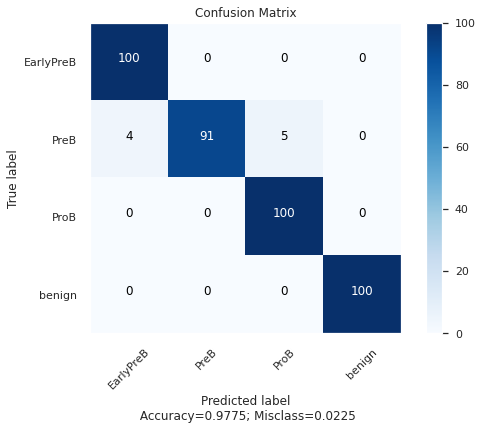

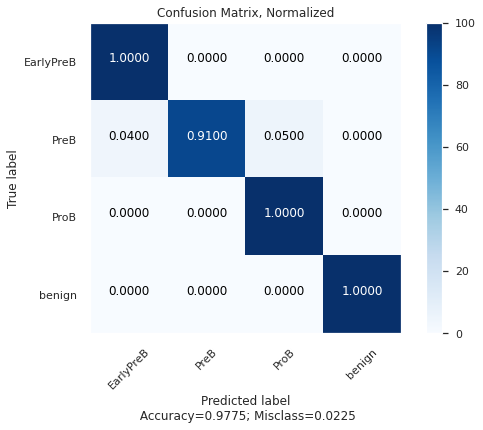

In [48]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          save_path=None):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout(pad=2.0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    
    if save_path is not None:
        plt.savefig(save_path, dpi=300,bbox_inches='tight')
    
    plt.show()

# Create and save the first confusion matrix plot
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix",
                      save_path   = '/kaggle/working/Matrix.png')

# Create and save the second confusion matrix plot
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = ['EarlyPreB','PreB','ProB','benign'],
                      title        = "Confusion Matrix, Normalized",
                      save_path   = '/kaggle/working/Matrix_Normalized.png')



In [49]:
train_gen.class_indices

{'EarlyPreB': 0, 'PreB': 1, 'ProB': 2, 'benign': 3}

In [50]:
class_metrics = metrics.classification_report(y_test,bin_predict,labels=[0, 1])
print(class_metrics)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.91      0.95       100

   micro avg       0.98      0.95      0.97       200
   macro avg       0.98      0.96      0.97       200
weighted avg       0.98      0.95      0.97       200



In [51]:
from sklearn.metrics import classification_report

# Calculate the classification report
class_metrics = classification_report(y_test, bin_predict, labels=[0, 1,2,3])

# Print the classification report
print("Classification Report:")
print(class_metrics)



Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.91      0.95       100
           2       0.95      1.00      0.98       100
           3       1.00      1.00      1.00       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [52]:
FP = matrix.sum(axis=0) - np.diag(matrix)
FN = matrix.sum(axis=1) - np.diag(matrix)
TP = np.diag(matrix)
TN = matrix[:].sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
TNR = TN/(TN+FP) 
PPV = TP/(TP+FP)
NPV = TN/(TN+FN)
FPR = FP/(FP+TN)
FNR = FN/(TP+FN)
FDR = FP/(TP+FP)

ACC = (TP+TN)/(TP+FP+FN+TN)

print('Other Metrics:')
MAE = mean_absolute_error(y_test, bin_predict)

print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (positive predictive value)-------------:', PPV)
print('Recall (Sensitivity, hit rate, true positive rate):', TPR)
print('Specificity (true negative rate)------------------:', TNR)
print('Negative Predictive Value-------------------------:', NPV)
print('Fall out (false positive rate)--------------------:', FPR)
print('False Negative Rate-------------------------------:', FNR)
print('False discovery rate------------------------------:', FDR)

Other Metrics:
MAE ----------------------------------------------: 0.0225
Accuracy -----------------------------------------: [0.99   0.9775 0.9875 1.    ]
Precision (positive predictive value)-------------: [0.96153846 1.         0.95238095 1.        ]
Recall (Sensitivity, hit rate, true positive rate): [1.   0.91 1.   1.  ]
Specificity (true negative rate)------------------: [0.98666667 1.         0.98333333 1.        ]
Negative Predictive Value-------------------------: [1.         0.97087379 1.         1.        ]
Fall out (false positive rate)--------------------: [0.01333333 0.         0.01666667 0.        ]
False Negative Rate-------------------------------: [0.   0.09 0.   0.  ]
False discovery rate------------------------------: [0.03846154 0.         0.04761905 0.        ]


In [53]:
# Convert NumPy arrays to Python floats or integers
TPR = float(TP[0]) / (TP[0] + FN[0])
TNR = float(TN[0]) / (TN[0] + FP[0])
PPV = float(TP[0]) / (TP[0] + FP[0])
NPV = float(TN[0]) / (TN[0] + FN[0])
FPR = float(FP[0]) / (FP[0] + TN[0])
FNR = float(FN[0]) / (TP[0] + FN[0])
FDR = float(FP[0]) / (TP[0] + FP[0])

ACC = float(TP[0] + TN[0]) / (TP[0] + FP[0] + FN[0] + TN[0])

MAE = float(mean_absolute_error(y_test, bin_predict))

# Create a nicely formatted output
output = f"""
Other Metrics:
MAE ----------------------------------------------: {MAE:.4f}
Accuracy -----------------------------------------: {ACC:.4f}
Precision (positive predictive value)-------------: {PPV:.4f}
Recall (Sensitivity, hit rate, true positive rate): {TPR:.4f}
Specificity (true negative rate)------------------: {TNR:.4f}
Negative Predictive Value-------------------------: {NPV:.4f}
Fall out (false positive rate)--------------------: {FPR:.4f}
False Negative Rate-------------------------------: {FNR:.4f}
False discovery rate------------------------------: {FDR:.4f}
"""

# Print the formatted output
print(output)




Other Metrics:
MAE ----------------------------------------------: 0.0225
Accuracy -----------------------------------------: 0.9900
Precision (positive predictive value)-------------: 0.9615
Recall (Sensitivity, hit rate, true positive rate): 1.0000
Specificity (true negative rate)------------------: 0.9867
Negative Predictive Value-------------------------: 1.0000
Fall out (false positive rate)--------------------: 0.0133
False Negative Rate-------------------------------: 0.0000
False discovery rate------------------------------: 0.0385



In [54]:
# preds = model.predict(X_test)
# #print(preds)
# print('Shape of preds: ', preds.shape)
# plt.figure(figsize = (12, 12))

# number = np.random.choice(preds.shape[0])

# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     number = np.random.choice(preds.shape[0])
#     pred = np.argmax(preds[number])
#     actual = (y_test[number])
#     col = 'g'
#     if pred != actual:
#         col = 'r'
#     plt.xlabel('N={} | P={} | GT={}'.format(number, pred, actual), color = col) #N= number P= prediction GT= actual (ground truth)
#     image= X_test[number]#cv2.cvtColor(X_test[number], cv2.COLOR_BGR2RGB)
#     plt.imshow(((image* 255).astype(np.uint8)), cmap='binary')
# plt.show()

In [55]:
# # Make predictions on the test data
# preds = model.predict(X_test)

# # Define the number of rows and columns for the grid
# rows, cols = 5, 5
# num_samples = rows * cols

# # Create a figure and axis for the grid of images
# fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# for i in range(num_samples):
#     # Select a random sample from the predictions
#     sample_index = np.random.choice(preds.shape[0])
#     pred = np.argmax(preds[sample_index])
#     actual = y_test[sample_index]
    
#     # Determine the label color based on prediction correctness
#     label_color = 'green' if pred == actual else 'red'
    
#     # Plot the image and labels
#     ax = axes[i // cols, i % cols]
#     ax.grid(False)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xlabel(f'N={sample_index} | P={pred} | GT={actual}', color=label_color)
#     ax.imshow((X_test[sample_index] * 255).astype(np.uint8), cmap='binary')

# # Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.5, hspace=0.5)

# # Show the grid of images
# plt.show()


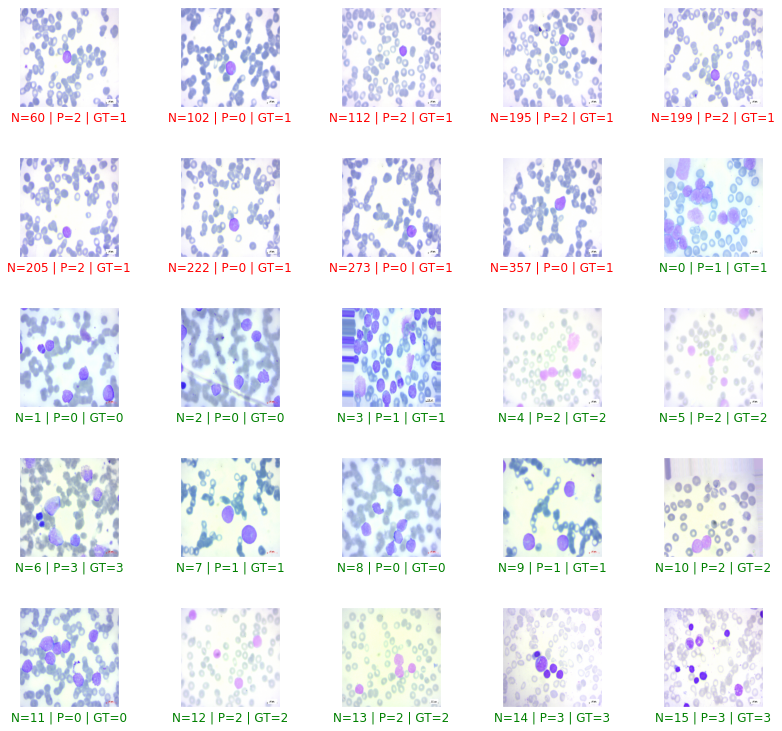

In [56]:
# Make predictions on the test data
preds = model.predict(X_test)

# Define the number of rows and columns for the grid
rows, cols = 5, 5
num_samples = rows * cols

# Create a figure and axis for the grid of images
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

false_samples = []  # Store false predictions
true_samples = []   # Store true predictions

for i in range(X_test.shape[0]):
    pred = np.argmax(preds[i])
    actual = y_test[i]

    # Determine if the prediction is correct or not
    if pred != actual:
        false_samples.append((i, pred, actual))
    else:
        true_samples.append((i, pred, actual))

# Sort false_samples and true_samples based on prediction correctness
false_samples.sort(key=lambda x: x[0])
true_samples.sort(key=lambda x: x[0])

# Concatenate false_samples and true_samples
all_samples = false_samples + true_samples

for i, (sample_index, pred, actual) in enumerate(all_samples[:num_samples]):
    # Determine the label color based on prediction correctness
    label_color = 'red' if i < len(false_samples) else 'green'
    
    # Plot the image and labels
    ax = axes[i // cols, i % cols]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f'N={sample_index} | P={pred} | GT={actual}', color=label_color)
    ax.imshow((X_test[sample_index] * 255).astype(np.uint8), cmap='binary')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the grid of images
plt.savefig('/kaggle/working/Prediction.png', dpi=300,bbox_inches='tight')
plt.show()


In [57]:
# from sklearn.model_selection import train_test_split
# import random
# from imutils import paths

# data_dir = '../input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'
# data_list = sorted(list(paths.list_images(data_dir)))

# random.seed(88)
# random.shuffle(data_list)

# train_list, test_list = train_test_split(data_list, train_size=0.90, shuffle=True, random_state=88)

# print('number of testing list -:', len(test_list))
# print('number of training list -:', len(train_list))

# # Display test image names along with their indexes
# for index, test_image_path in enumerate(test_list):
#     print(f'Test Image {index}: {test_image_path}')


In [58]:
# # Find the index of the specific false image you want to analyze
# target_index = None
# for i, (sample_index, pred, actual) in enumerate(all_samples):
#     if sample_index == 192:  # Change 121 to the index of the image you want to analyze
#         target_index = i
#         break

# if target_index is not None:
#     # Extract information about the specific false image
#     sample_index, pred, actual = all_samples[target_index]

#     # Load the image from the test data
#     target_image = (X_test[sample_index] * 255).astype(np.uint8)

#     # Get the label for the specific image
#     target_label = y_test[sample_index]

#     # Determine the label color based on prediction correctness
#     label_color = 'red' if target_index < len(false_samples) else 'green'

#     # Display the image, its label, and its prediction
#     plt.figure(figsize=(6, 6))
#     plt.imshow(target_image, cmap='binary')
#     plt.title(f'N={sample_index} | P={pred} | GT={actual}', color=label_color)
#     plt.xlabel(f'Actual Label: {actual}\nPredicted Label: {pred}', color=label_color)
#     plt.xticks([])
#     plt.yticks([])
#     plt.savefig('/kaggle/working/False_im.png', dpi=300)
#     plt.show()
# else:
#     print("Target image not found in the false samples.")



TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

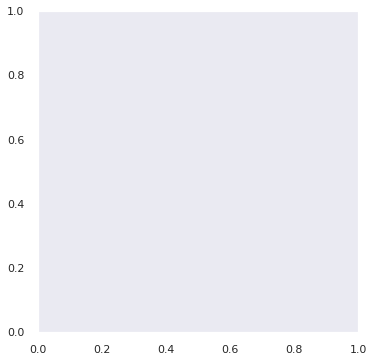

In [59]:
plt.imshow(x)
plt.title("Preprocessed Image")
plt.axis('off')  # Turn off the axis labels
plt.savefig('/kaggle/working/Presentation3.png', dpi=300)
plt.show()

In [ ]:
# Step 1: Preprocess 'x' to match the input shape of your model
input_shape = (224, 224, 3)  # Assuming your model expects input shape (224, 224, 3)
preprocessed_x = cv2.resize(x, input_shape[:2])  # Resize to (224, 224)
preprocessed_x = preprocessed_x / 255.0  # Normalize to [0, 1] (if needed)

# Step 2: Use your trained model to make a prediction on 'x'
# Assuming your model is named 'model'
prediction = model.predict(np.expand_dims(preprocessed_x, axis=0))  # Expand dimensions to create a batch of size 1

# Step 3: Interpret the prediction
class_names = ['early Pre-B', 'Pre-B', 'Pro-B', 'Benign']  # List of class names
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class}")


# **Step 5:** Save the model
